In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
#we are going to initialize some constant
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1]


# Data Visualization

(32, 256, 256, 3)
[1 0 1 1 2 1 0 1 1 1 1 0 1 0 0 2 1 1 1 0 1 0 0 1 0 0 2 1 0 1 1 0]


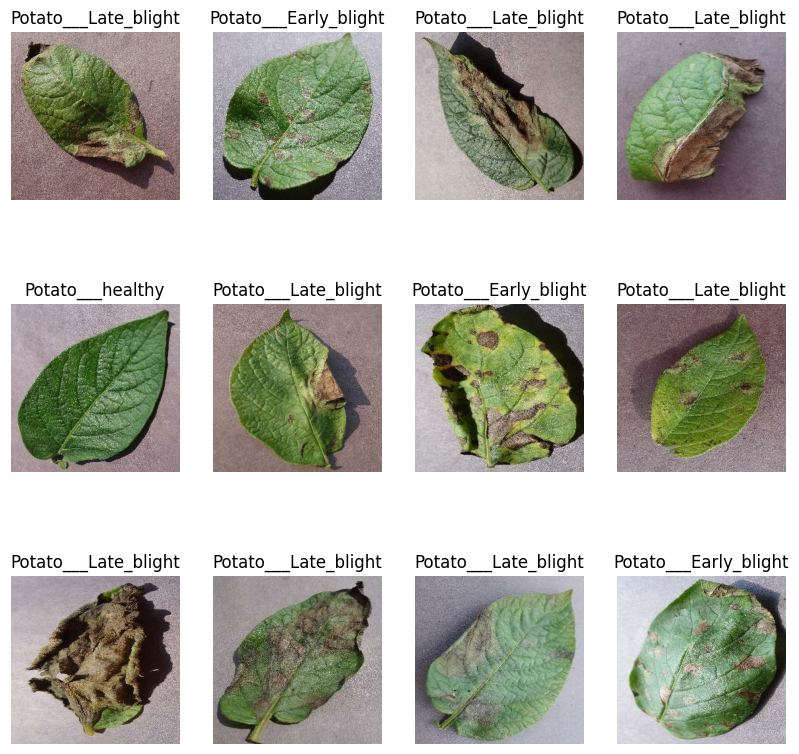

In [6]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) #for showing image into matrix form
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        
        plt.imshow(image_batch[i].numpy().astype("uint8")) #here i is in tensor form so we convert this into numpy array and since numpy array is in float so we use uint8
        #since we do not need axis so we will off this
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# dividing dataset into training and test set

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size =10000):
    assert(train_split+test_split+val_split) ==1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #by using seed we get same prediction
        
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
#there are 54*32 images are in train data set, since we made batch of 32 in this project

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #we did fetch to increase the performance of dataset
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)# we did normalizations so we divided by 255

[[[0.36078432 0.34117648 0.36862746]
  [0.3372549  0.31764707 0.34509805]
  [0.3372549  0.31764707 0.34509805]
  ...
  [0.5686275  0.54901963 0.5764706 ]
  [0.56078434 0.5411765  0.5686275 ]
  [0.5568628  0.5372549  0.5647059 ]]

 [[0.36862746 0.34901962 0.3764706 ]
  [0.34901962 0.32941177 0.35686275]
  [0.34509805 0.3254902  0.3529412 ]
  ...
  [0.5803922  0.56078434 0.5882353 ]
  [0.5764706  0.5568628  0.58431375]
  [0.5764706  0.5568628  0.58431375]]

 [[0.3764706  0.35686275 0.38431373]
  [0.3647059  0.34509805 0.37254903]
  [0.35686275 0.3372549  0.3647059 ]
  ...
  [0.57254905 0.5529412  0.5803922 ]
  [0.57254905 0.5529412  0.5803922 ]
  [0.5764706  0.5568628  0.58431375]]

 ...

 [[0.5176471  0.49803922 0.5254902 ]
  [0.5019608  0.48235294 0.50980395]
  [0.5176471  0.49803922 0.5254902 ]
  ...
  [0.5921569  0.5803922  0.6156863 ]
  [0.58431375 0.57254905 0.60784316]
  [0.5764706  0.5647059  0.6       ]]

 [[0.49803922 0.47843137 0.5058824 ]
  [0.49019608 0.47058824 0.49803922]


# data resizing and rescaling

In [21]:
resize_and_rescale = tf.keras.Sequential([  
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), #we resizing and rescaling because if in future model me 256 and 256 ka image nhi hua to ye resize kr dega 
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

# data augmentation

data augmentation help us to make images use better, like in our final model if the input image is flip, zoomed , rotated or having more contrast so this will help us to deal with that.

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Building model

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # used softmax to normalize the probability
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS

)

Epoch 1/50
54/54 [==============================] - 238s 4s/step - loss: 0.9033 - accuracy: 0.4774 - val_loss: 0.8422 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 212s 4s/step - loss: 0.6803 - accuracy: 0.7008 - val_loss: 0.4643 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 215s 4s/step - loss: 0.4015 - accuracy: 0.8339 - val_loss: 0.4297 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 212s 4s/step - loss: 0.3206 - accuracy: 0.8686 - val_loss: 0.2423 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 209s 4s/step - loss: 0.2775 - accuracy: 0.8843 - val_loss: 0.4188 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 211s 4s/step - loss: 0.2834 - accuracy: 0.8837 - val_loss: 0.3386 - val_accuracy: 0.8490
Epoch 7/50
54/54 [==============================] - 212s 4s/step - loss: 0.2003 - accuracy: 0.9219 - val_loss: 0.1432 - val_accuracy: 0.9375
Epoch 8/50
54

In [27]:
len(test_ds)

8

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 15s 1s/step - loss: 0.0373 - accuracy: 0.9883


In [29]:
scores

[0.0373433493077755, 0.98828125]

In [30]:
history.history.keys() #this will help us to plot and also will tell about that which parameter we used to train the model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
len(history.history['accuracy'])

50

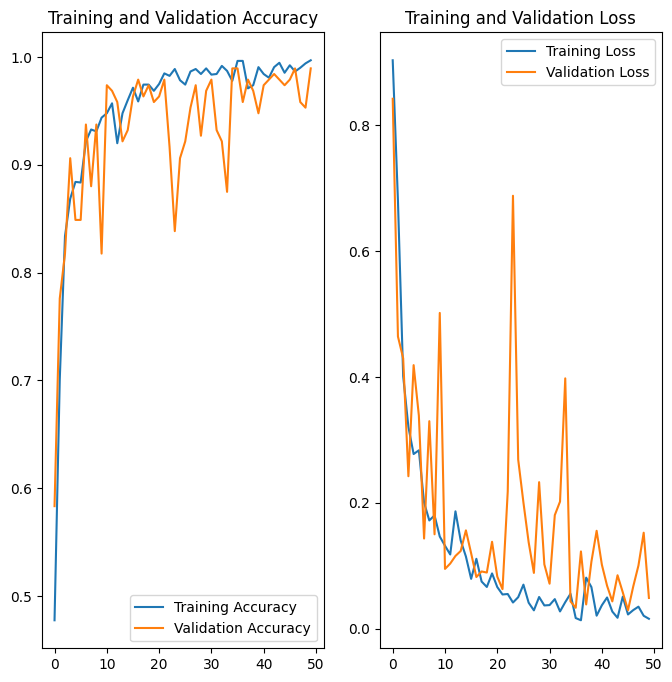

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ='Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Label: Potato___healthy
1/1 [==============================] - 1s 1s/step
Potato___healthy


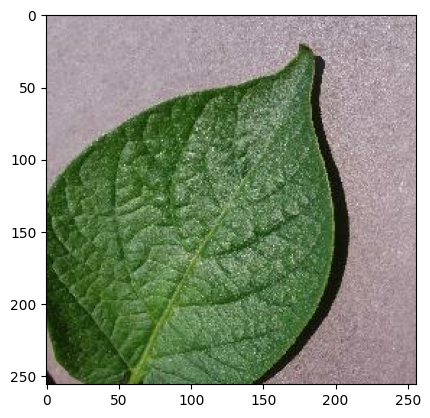

In [34]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print("First image to predict")
    plt.imshow(first_image)
    print('Label:',class_names[ labels_batch[0].numpy()])
    
    batch_prediction = model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 134ms/step


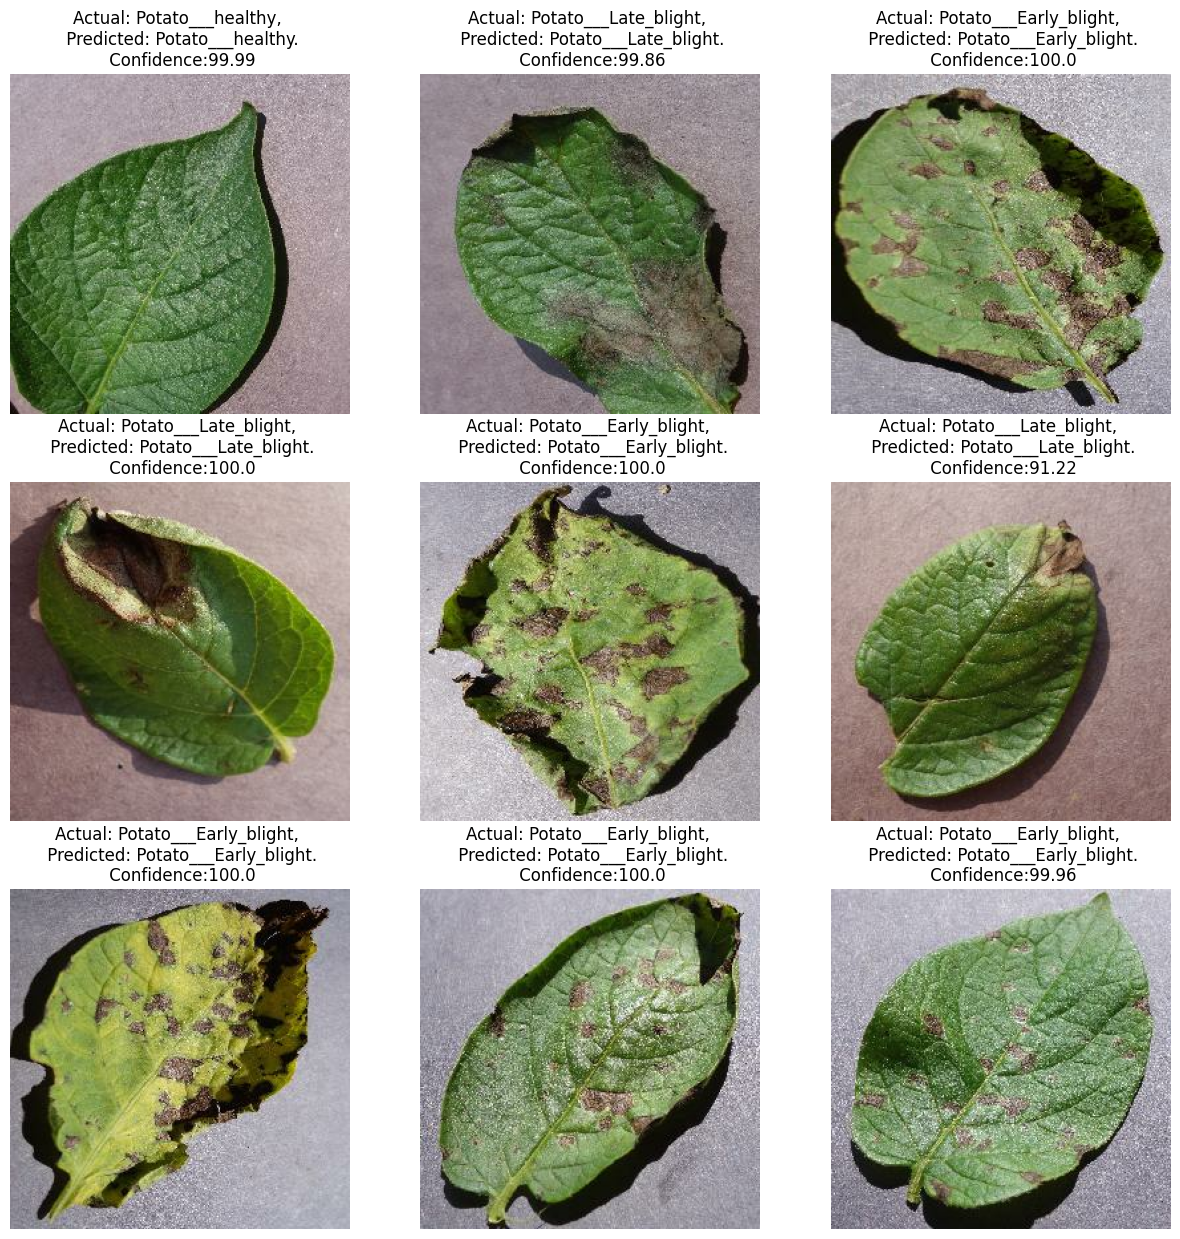

In [36]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence:{confidence}")
        plt.axis("off")

In [40]:
import os
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) +1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'